# BIBLIOTECAS

In [1]:
import json
import time
from datetime import datetime

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from pyvis.network import Network
from scipy.stats import kstest, powerlaw

# Configurações para exibir todas as linhas e colunas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Configuração para exibir todo o conteúdo das células
pd.set_option("display.max_colwidth", None)

# ARQUIVOS

In [2]:
# Arquivos de entrada
json_file = "..\small_world_linkedin\data\linkedin_graph.json"  # Substitua pelo caminho do arquivo JSON
csv_file = "..\small_world_linkedin\data\linkedin_v5.csv"    # Substitua pelo caminho do arquivo CSV


# FUNÇÕES DE ANÁLISE

## PROCESSA OS DADOS

In [3]:
def process_data(json_file, csv_file):
    # Carregar JSON
    with open(json_file, 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    
    # Carregar CSV
    csv_data = pd.read_csv(csv_file, sep='|')
    csv_data['Connected On'] = pd.to_datetime(csv_data['Connected On'])
    
    # Criar um DataFrame para os relacionamentos do JSON
    relationships = []
    for url, names in json_data.items():
        for name in names:
            relationships.append({"URL": url, "Connection Name": name})
    
    json_df = pd.DataFrame(relationships)
    
    # Mesclar os dois DataFrames usando o campo "URL"
    combined_df = pd.merge(csv_data, json_df, on="URL", how="inner")
    
    return combined_df, csv_data


## CRIA OS GRAFOS

In [4]:
# Função para criar e exibir o grafo
def create_graph(dataframe):
    # Criar o grafo
    graph = nx.Graph()
    
    # Adicionar nós e arestas no grafo
    for _, row in dataframe.iterrows():
        # Nó principal (do CSV)
        main_node = f'{row["First Name"]} {row["Last Name"]}'
        graph.add_node(main_node, 
                       title=f'Company: {row["Company"]}, Position: {row["Position"]}, Days Connected: {row["Days Connected"]}',
                       group="Main",
                       company=row['Company'], position=row['Position'], days_connected = row["Days Connected"])
        
        # Nós de conexão (do JSON)
        connection_node = row["Connection Name"]
        graph.add_node(connection_node, group="Connection")
        
        # Aresta entre o nó principal e o nó de conexão
        graph.add_edge(main_node, connection_node)
    
    # Configurar visualização com pyvis
    net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")
    net.from_nx(graph)
    net.show_buttons(filter_=['physics'])
    net.show("connections_graph.html")
    return graph

## AVALIA MÉTRICAS

In [5]:
# Step 4: Analyze the graph
def analyze_graph(G):
    clustering_coefficient = nx.average_clustering(G)
    average_path_length = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
    return clustering_coefficient, average_path_length

In [6]:
# Step 5: Identify key influencers
def compute_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight="weight")
    eigenvector_centrality = nx.eigenvector_centrality(G)

    centrality_df = pd.DataFrame({
        'Node': list(G.nodes),
        'Degree Centrality': degree_centrality.values(),
        'Betweenness Centrality': betweenness_centrality.values(),
        'Eigenvector Centrality': eigenvector_centrality.values(),
        'Days Connected': [G.nodes[node].get("days_connected", None) for node in G.nodes()]
    })

    centrality_df["Score"] = centrality_df[
        ["Degree Centrality", "Betweenness Centrality", "Eigenvector Centrality"]
    ].mean(axis=1)

    centrality_df = centrality_df.sort_values(by='Degree Centrality', ascending=False)
    return centrality_df, degree_centrality

In [7]:
# Step 6: Visualize degree distribution
def plot_degree_distribution(G):
    degrees = [degree for _, degree in G.degree()]
    plt.figure(figsize=(8, 6))
    plt.hist(degrees, bins=range(1, max(degrees) + 2), align='left', edgecolor='black')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Check for scale-free network
    plt.figure(figsize=(8, 6))
    plt.loglog(sorted(degrees, reverse=True), marker='o', linestyle='None')
    plt.title("Log-Log Plot of Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Fit power-law distribution (ensure dataset size is sufficient)
    if len(degrees) < 30:
        print("Dataset too small to reliably fit a power-law distribution.")
        return

    degrees = np.array(degrees)
    alpha, loc, scale = powerlaw.fit(degrees)

    # Plot power-law fit
    plt.figure(figsize=(8, 6))
    plt.hist(degrees, bins=30, density=True, alpha=0.7, label='Degree Distribution')
    x = np.linspace(min(degrees), max(degrees), 100)
    plt.plot(x, powerlaw.pdf(x, alpha, loc, scale), 'r-', label=f'Power Law Fit (α={alpha:.2f})')
    plt.xlabel("Degree")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Degree Distribution and Power Law Fit")
    plt.show()

    # Perform Kolmogorov-Smirnov test
    D, p_value = kstest(degrees, 'powerlaw', args=(alpha, loc, scale))
    print(f"Kolmogorov-Smirnov Test: D = {D}, p-value = {p_value}")

In [8]:
# Step 7: Visualize the graph interactively with key hubs highlighted
def visualize_graph_interactive(G, degree_centrality, title="Graph Visualization"):
    pos = nx.spring_layout(G, weight='weight')

    # Extracting edge and node information for Plotly
    edge_x = []
    edge_y = []
    edge_weights = []
    filtered_edges = [edge for edge in G.edges(data=True) if edge[2].get('weight', 1) > 1]
    for edge in filtered_edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        edge_weights.append(edge[2].get('weight', 1))

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Assigning node colors and sizes based on company
    company_colors = {company: f"hsl({i * 360 / len(set(nx.get_node_attributes(G, 'company').values()))}, 70%, 50%)" 
                      for i, company in enumerate(set(nx.get_node_attributes(G, 'company').values()))}

    node_x = []
    node_y = []
    node_text = []
    node_color = []
    node_size = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"{node}<br>Company: {G.nodes[node].get('company', 'N/A')}<br>Degree Centrality: {degree_centrality[node]:.4f}<br>Days Connected: {G.nodes[node].get('days_connected', 'N/A')}")
        node_color.append(company_colors.get(G.nodes[node].get('company', 'N/A'), '#cccccc'))
        node_size.append(10)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=False,
            color=node_color,
            size=node_size,
            line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title=title,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0,l=0,r=0,t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

    fig.show()


In [9]:
def plot_graph_test(graph):
    pos = nx.spring_layout(graph)
    xn, yn = zip(*[pos[k] for k in graph.nodes()])
    xe, ye = [], []
    for e in graph.edges():
        xe += [pos[e[0]][0], pos[e[1]][0], None]
        ye += [pos[e[0]][1], pos[e[1]][1], None]

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=xe, y=ye, mode="lines", line=dict(color="lightblue"), hoverinfo="none")
    )
    fig.add_trace(
        go.Scatter(
            x=xn,
            y=yn,
            mode="markers",
            marker=dict(size=10, color="red"),
            text=list(graph.nodes()),
            hoverinfo="text",
        )
    )
    fig.update_layout(
        title="Graph Representation of LinkedIn Connections", showlegend=False
    )
    
    fig.show()

In [10]:
def interest_clustering_coefficient_undirected(graph, attribute="Company"):
    """
    Calculate the Interest Clustering Coefficient (ICC) for each node in an undirected graph.

    Parameters:
        graph (networkx.Graph): The undirected graph.
        attribute (str): Node attribute to measure similarity (e.g., 'Company').

    Returns:
        icc_dict (dict): Interest clustering coefficient for each node.
    """
    icc_dict = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if len(neighbors) < 2:
            icc_dict[node] = 0.0
            continue
        
        same_interest_count = 0
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                attr_i = graph.nodes[neighbors[i]].get(attribute, None)
                attr_j = graph.nodes[neighbors[j]].get(attribute, None)
                if attr_i and attr_j and attr_i == attr_j:
                    same_interest_count += 1
        
        possible_pairs = len(neighbors) * (len(neighbors) - 1) / 2
        icc_dict[node] = same_interest_count / possible_pairs if possible_pairs > 0 else 0.0

    return pd.DataFrame.from_dict(icc_dict, 'index', columns=['ICC']).reset_index().rename(columns={'index': 'Nome'}).sort_values(by='ICC', ascending=False)


In [11]:
def add_proximity_weights(graph, attribute="company"):
    """
    Add edge weights to the graph based on proximity/similarity of a given attribute.

    Parameters:
        graph (networkx.Graph): The undirected graph.
        attribute (str): Node attribute to calculate similarity (e.g., 'Company').

    Returns:
        graph (networkx.Graph): Updated graph with weighted edges.
    """
    for u, v in graph.edges():
        attr_u = graph.nodes[u].get(attribute, None)
        attr_v = graph.nodes[v].get(attribute, None)
        weight = 1 if attr_u and attr_v and attr_u == attr_v else 0.5  # Example weight logic
        graph[u][v]["weight"] = weight
    return graph


In [12]:
def calculate_betweenness(graph):
    """
    Calculate betweenness centrality for nodes in the graph.

    Parameters:
        graph (networkx.Graph): The undirected graph.

    Returns:
        betweenness_dict (dict): Betweenness centrality for each node.
    """
    betweenness_dict = nx.betweenness_centrality(graph, weight="weight")
    return pd.DataFrame.from_dict(betweenness_dict, 'index', columns=['BTW']).reset_index().rename(columns={'index': 'Nome'}).sort_values(by='BTW', ascending=False)


In [13]:
def calculate_average_geodesic_length(graph):
    """
    Calculate the average geodesic length for each node in the graph.

    Parameters:
        graph (networkx.Graph): The undirected graph.

    Returns:
        geodesic_length_dict (dict): Average geodesic length for each node.
    """
    geodesic_length_dict = {}
    for node in graph.nodes():
        lengths = nx.single_source_dijkstra_path_length(graph, node, weight="weight")
        geodesic_length_dict[node] = sum(lengths.values()) / (len(lengths) - 1)  # Exclude self

    return pd.DataFrame.from_dict(geodesic_length_dict, 'index', columns=['AGL']).reset_index().rename(columns={'index': 'Nome'}).sort_values(by='AGL', ascending=False)


# EXECUTA OS PROCESSOS

In [14]:
# Processar os dados
combined_data, csv_data = process_data(json_file, csv_file)

# Criar e exibir o grafo
graph = create_graph(combined_data)

# Adicionar pesos baseados na proximidade
graph = add_proximity_weights(graph, attribute="company")



connections_graph.html


In [23]:
combined_data.to_csv("..\small_world_linkedin\data\linkedin_graph.csv", sep='|', index=False)

In [15]:
# Calcular Interest Clustering Coefficient
icc = interest_clustering_coefficient_undirected(graph, attribute="company")
print("Interest Clustering Coefficient:\n", icc.head())

# Calcular Betweenness Centrality
betweenness = calculate_betweenness(graph)
print("\nBetweenness Centrality:\n", betweenness.head())

# Calcular Geodesic Length
geodesic_lengths = calculate_average_geodesic_length(graph)
print("\nAverage Geodesic Length:\n", geodesic_lengths.head())

Interest Clustering Coefficient:
                         Nome  ICC
656  Murilo Gomes dos Santos  1.0
635       TRAZÍBULO CALDEIRA  1.0
654        Matheus Polycarpo  1.0
649     Roberto Cremon Godoy  1.0
650             SILMAR HORTA  1.0

Betweenness Centrality:
                              Nome       BTW
663            Guilherme Lourenço  0.583298
102                 Adriano Moala  0.083658
134  Ana Gabriela Oliveira Bonfim  0.079503
44           Amanda Souza Noronha  0.068989
477                  Cibele Russo  0.055084

Average Geodesic Length:
                      Nome       AGL
569       Sydney Ipiranga  2.054363
594         Fellipe Mello  1.966381
640        Lucas Medeiros  1.957797
639        Carla Biasotto  1.957797
653  Ana Claudia Campaner  1.955651


In [16]:
icc.ICC.mean(), betweenness.BTW.mean(), geodesic_lengths.AGL.mean()

(np.float64(0.29536489604644534),
 np.float64(0.002682377474765239),
 np.float64(1.4379767014101776))

In [17]:
clustering_coefficient, average_path_length = analyze_graph(graph)

print(f"Clustering Coefficient: {clustering_coefficient}")

if average_path_length is not None:
    print(f"Average Path Length: {average_path_length}")
else:
    print("Graph is not connected; cannot compute average path length.")

Clustering Coefficient: 0.5355086209344737
Average Path Length: 2.789695483343552


In [18]:
top_influencers, degree_centrality = compute_centrality_measures(graph)

top_influencers.head(10)

,Node,Degree Centrality,Betweenness Centrality,Eigenvector Centrality,Days Connected,Score
663,Guilherme Lourenço,0.426323,0.583298,0.239597,4890.0,0.416406
44,Amanda Souza Noronha,0.273247,0.068989,0.234402,4551.0,0.192213
31,Clodoaldo Azevedo,0.243205,0.033361,0.228820,3413.0,0.168462
67,Daniel Braz,0.240343,0.040279,0.217956,4043.0,0.166193
134,Ana Gabriela Oliveira Bonfim,0.210300,0.079503,0.075794,2044.0,0.121866
102,Adriano Moala,0.204578,0.083658,0.071676,277.0,0.119971
203,Angela Achcar,0.181688,0.026612,0.081751,1545.0,0.096684
184,Angelica Gozzani Tozetti,0.180258,0.035777,0.086173,752.0,0.100736
60,Derrick Mackenzie,0.180258,0.023861,0.187661,4539.0,0.130593
128,Anderson Maciel Souza,0.178827,0.020140,0.077013,1638.0,0.091993


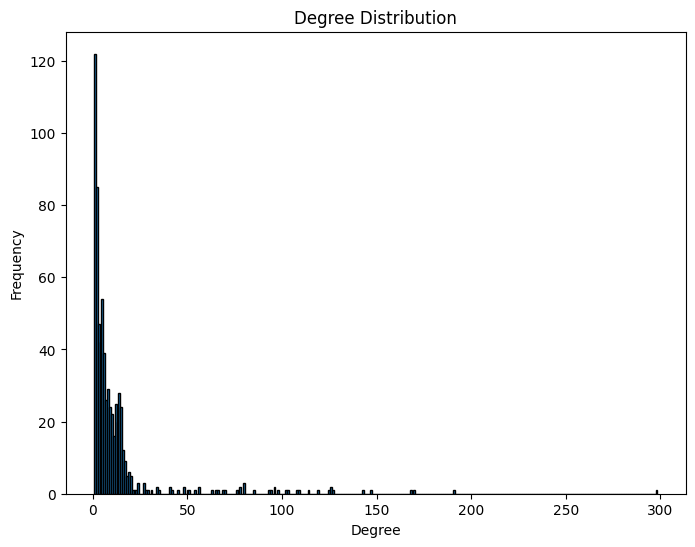

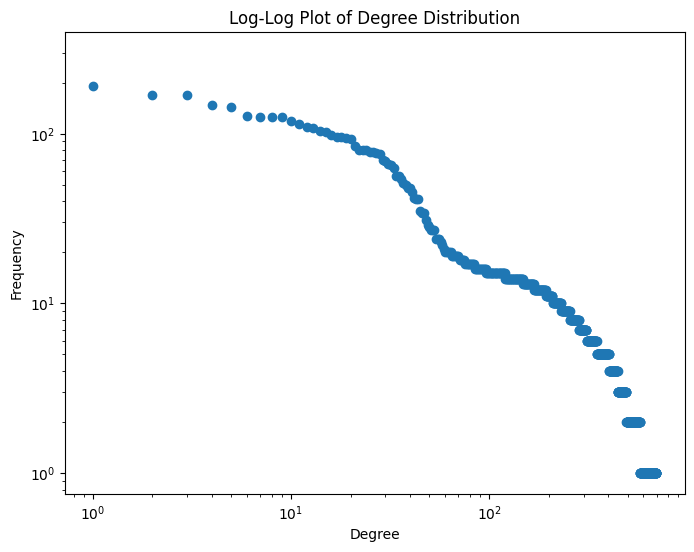

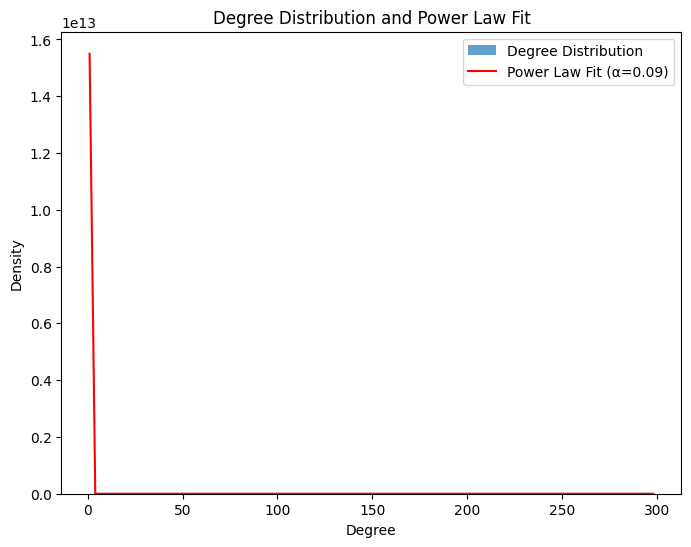

Kolmogorov-Smirnov Test: D = 0.4099716220202684, p-value = 6.507950723671154e-107


In [19]:
plot_degree_distribution(graph)

In [20]:
visualize_graph_interactive(graph, degree_centrality, title="Final Interactive Graph with Key Hubs Highlighted")

In [21]:
plot_graph_test(graph)